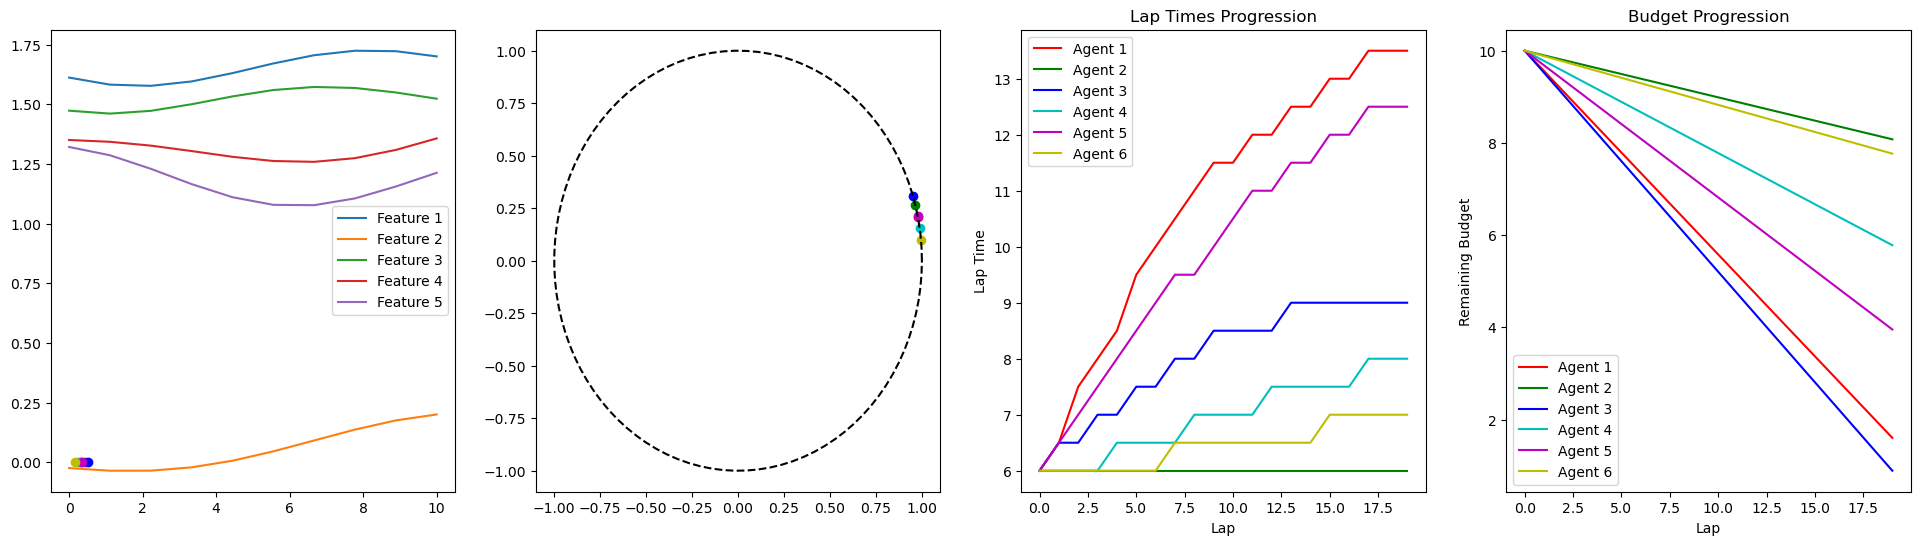

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Initialize global variables for history and best states
last_successful_feature = None
last_successful_perturbation = None
last_best_agent_state = None
last_best_lap_time = None

# # Initialize agent with budget
# def initialize_agent_with_budget(n, budget, seed = 42):
#     if seed is not None:
#         np.random.seed(seed)
#     agent = np.random.randn(n)
#     return agent, budget

# # Hill climb optimization for each agent
# def optimize_agent(agent, lap_time, prev_lap_time, budget, delta=0.1):
#     if lap_time < prev_lap_time and budget > 0:
#         perturbation = np.random.uniform(-delta, delta)
#         feature_to_change = np.random.randint(0, len(agent))
#         agent[feature_to_change] += perturbation
#         budget -= np.abs(perturbation)
#     return agent, max(budget, 0)

# Fourier-based track feature generator
def generate_fourier(L, n, N=5, kappa=0.03): # L: length of track, n: number of features, N: number of frequencies, kappa: small for smooth track
    x = np.linspace(0, 1, L)
    track = np.zeros((L, n))
    
    # Generate frequencies and scales based on kappa
    freqs = [kappa * (i + 1) for i in range(N)]
    scales = [kappa * 0.5 * (i + 1) for i in range(N)]
    
    for j in range(n):
        A0 = np.random.randn()
        track[:, j] += A0
        
        for i in range(1, N + 1):
            An = np.random.randn() * scales[i-1]
            Bn = np.random.randn() * scales[i-1]
            freq = freqs[i-1]
            
            track[:, j] += An * np.cos(2 * np.pi * freq * i * x) + Bn * np.sin(2 * np.pi * freq * i * x)
            
    return track

# Initialize agent features
def initialize_agent(n, seed = 42):
    if seed is not None:
        np.random.seed(seed)
    return np.random.randn(n)

# Compute speed
def speed(agent, track_features, alpha=1.0, beta=1.0):
    norm_agent = np.linalg.norm(agent)
    norm_track = np.linalg.norm(track_features)
    return alpha + beta * np.dot(agent, track_features) / (norm_agent * norm_track)

# Main function for simulation
def main(num_agents=3, num_laps=10, initial_budget=1.0):
    L, n, alpha, beta, dt = 10, 5, 1.0, 1.0, 0.5
    
    global last_successful_feature, last_successful_perturbation, last_best_agent_state, last_best_lap_time
    last_successful_feature = np.zeros(num_agents, dtype=int)
    last_successful_perturbation = np.zeros(num_agents)
    last_best_agent_state = [np.zeros(n) for _ in range(num_agents)]
    last_best_lap_time = np.inf * np.ones(num_agents)
    
    
    track = generate_fourier(L, n)
    agents = [initialize_agent(n) for _ in range(num_agents)]
    budgets = np.ones(num_agents) * initial_budget

    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    lap_times_history = np.zeros((num_laps, num_agents))
    budget_history = np.zeros((num_laps, num_agents))
    prev_lap_times = np.inf * np.ones(num_agents)

    def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
                        last_successful_feature, last_successful_perturbation,
                        budget, agent_idx, delta=0.5, min_improvement=0.05):
        
        # Initialize if not provided
        if last_best_lap_time[agent_idx] is None:
            last_best_lap_time[agent_idx] = float('inf')
        
        if lap_time < last_best_lap_time[agent_idx] - min_improvement:
            # Update best-known state and lap time
            last_best_agent_state[agent_idx] = np.copy(agent)
            last_best_lap_time[agent_idx] = lap_time
            
            # Random perturbation
            perturbation = np.random.uniform(-delta, delta)
            feature_to_change = np.random.randint(0, len(agent))
            
            if budget - np.abs(perturbation) >= 0:
                agent[feature_to_change] += perturbation
                budget -= np.abs(perturbation)
                
                last_successful_feature[agent_idx] = feature_to_change
                last_successful_perturbation[agent_idx] = perturbation
                
        else:
            feature_to_change = last_successful_feature[agent_idx]
            perturbation = last_successful_perturbation[agent_idx]
            
            if feature_to_change is not None and perturbation != 0 and budget - np.abs(perturbation) >= 0:
                agent[feature_to_change] += perturbation
                budget -= np.abs(perturbation)
            else:
                agent = np.copy(last_best_agent_state[agent_idx])
                last_successful_feature[agent_idx] = None
                last_successful_perturbation[agent_idx] = 0

        return agent, max(budget, 0)



    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
    
    # Plot features
    for i in range(n):
        ax1.plot(np.linspace(0, L, L), track[:, i], label=f'Feature {i+1}')
    ax1.legend()
    
    points = [ax1.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    circles = [ax2.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    ax2.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--')
    
    for lap in range(num_laps):
        positions = np.zeros(num_agents)  # Reset for a new lap
        lap_times = np.zeros(num_agents)

        while np.any(positions < L):
            for i in range(num_agents):
                if positions[i] >= L:
                    continue  # Skip agents that have finished the lap
                agent = agents[i]
                s = positions[i]
                track_features = track[int(s) % L]
                v = speed(agent, track_features, alpha, beta)
                positions[i] += v * dt
                lap_times[i] += dt
                
                # Update visualization
                points[i].set_data(positions[i] % L, 0)
                theta = 2 * np.pi * (positions[i] % L) / L
                circles[i].set_data(np.cos(theta), np.sin(theta))

            clear_output(wait=True)
            display(fig)
            plt.pause(0.01)
        
        lap_times_history[lap, :] = lap_times
        budget_history[lap, :] = budgets

        # Optimize agents based on lap times
        for i in range(num_agents):
            agents[i], budgets[i] = optimize_agent(agents[i], lap_times[i], last_best_lap_time, last_best_agent_state, last_successful_feature, last_successful_perturbation, budgets[i], i, delta=0.5, min_improvement=0.05)
            # optimize_agent(agents[i], lap_times[i], prev_lap_times[i], budgets[i], i, delta=0.5, min_improvement=0.05, last_best_agent_state=last_best_agent_state, last_successful_feature=last_successful_feature, last_successful_perturbation=last_successful_perturbation)

        prev_lap_times = lap_times

        # Plot lap times history
        ax3.clear()
        for i in range(num_agents):
            ax3.plot(range(lap + 1), lap_times_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax3.legend()
        ax3.set_title('Lap Times Progression')
        ax3.set_xlabel('Lap')
        ax3.set_ylabel('Lap Time')

        # Plot budget history
        ax4.clear()
        for i in range(num_agents):
            ax4.plot(range(lap + 1), budget_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax4.legend()
        ax4.set_title('Budget Progression')
        ax4.set_xlabel('Lap')
        ax4.set_ylabel('Remaining Budget')

main(num_agents=6, num_laps=50, initial_budget=10.0)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Initialize global variables for history and best states
last_successful_feature = None
last_successful_perturbation = None
last_best_agent_state = None
last_best_lap_time = None

def generate_fourier(L, n, N=10, kappa=0.25): # L: length of track, n: number of features, N: number of frequencies, kappa: small for smooth track
    x = np.linspace(0, 1, L)
    track = np.zeros((L, n))

    # Highest frequency based on kappa
    highest_frequency = int(N * kappa)
    
    for j in range(n):
        A0 = np.random.randn()  
        track[:, j] += A0
        
        for i in range(1, highest_frequency + 1):  # Loop up to the highest frequency
            An = np.random.randn()
            Bn = np.random.randn()
            
            track[:, j] += An * np.cos(2 * np.pi * i * x) + Bn * np.sin(2 * np.pi * i * x)
            
    return track

# Initialize agent features
def initialize_agent(n, seed = 42):
    if seed is not None:
        np.random.seed(seed)
    return np.random.randn(n)

# Compute speed
def speed(agent, track_features, alpha=1.0, beta=1.0):
    norm_agent = np.linalg.norm(agent)
    norm_track = np.linalg.norm(track_features)
    return alpha + beta * np.dot(agent, track_features) / (norm_agent * norm_track)

# Main function for simulation
def main(num_agents=3, num_laps=10, initial_budget=1.0):
    L, n, alpha, beta, dt = 10, 5, 1.0, 1.0, 0.5
    
    global last_successful_feature, last_successful_perturbation, last_best_agent_state, last_best_lap_time
    last_successful_feature = np.zeros(num_agents, dtype=int)
    last_successful_perturbation = np.zeros(num_agents)
    last_best_agent_state = [np.zeros(n) for _ in range(num_agents)]
    last_best_lap_time = np.inf * np.ones(num_agents)
    
    
    track = generate_fourier(L, n)
    agents = [initialize_agent(n) for _ in range(num_agents)]
    budgets = np.ones(num_agents) * initial_budget

    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    lap_times_history = np.zeros((num_laps, num_agents))
    budget_history = np.zeros((num_laps, num_agents))
    prev_lap_times = np.inf * np.ones(num_agents)

    def rotate_features(agent, theta, u, v):
        """Rotates agent's features in the plane defined by vectors u and v."""
        I = np.identity(len(agent))
        rotation_matrix = (I + (np.cos(theta) - 1) * (np.outer(u, u) + np.outer(v, v)) +
                        np.sin(theta) * (np.outer(u, v) - np.outer(v, u)))
        return np.dot(rotation_matrix, agent)

    def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
                    budget, agent_idx, min_improvement=0.05, rotation_scale=0.1):
        # Initialize if not provided
        if last_best_lap_time[agent_idx] is None:
            last_best_lap_time[agent_idx] = float('inf')

        if lap_time <= last_best_lap_time[agent_idx]:
            # Update best-known state and lap time
            last_best_agent_state[agent_idx] = np.copy(agent)
            last_best_lap_time[agent_idx] = lap_time

            # Generate random rotation angle and basis vectors
            theta = np.random.uniform(-rotation_scale, rotation_scale)
            u, v = np.random.randn(len(agent)), np.random.randn(len(agent))
            u /= np.linalg.norm(u)
            v /= np.linalg.norm(v)

            # Rotate features
            agent = rotate_features(agent, theta, u, v)
            budget -= np.abs(theta)
        else:
            # Roll back to the best-known state if no improvement
            agent = np.copy(last_best_agent_state[agent_idx])

        return agent, budget




    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
    
    # Plot features
    for i in range(n):
        ax1.plot(np.linspace(0, L, L), track[:, i], label=f'Feature {i+1}')
    ax1.legend()
    
    points = [ax1.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    circles = [ax2.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    ax2.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--')
    
    for lap in range(num_laps):
        positions = np.zeros(num_agents)  # Reset for a new lap
        lap_times = np.zeros(num_agents)

        while np.any(positions < L):
            for i in range(num_agents):
                if positions[i] >= L:
                    continue  # Skip agents that have finished the lap
                agent = agents[i]
                s = positions[i]
                track_features = track[int(s) % L]
                v = speed(agent, track_features, alpha, beta)
                positions[i] += v * dt
                lap_times[i] += dt
                
                # Update visualization
                points[i].set_data(positions[i] % L, 0)
                theta = 2 * np.pi * (positions[i] % L) / L
                circles[i].set_data(np.cos(theta), np.sin(theta))

            clear_output(wait=True)
            display(fig)
            plt.pause(0.01)
        
        lap_times_history[lap, :] = lap_times
        budget_history[lap, :] = budgets

        # Optimize agents based on lap times
        for i in range(num_agents):
            agents[i], budgets[i] = optimize_agent(agents[i], lap_times[i], last_best_lap_time, last_best_agent_state, budgets[i], i, min_improvement=0.05)
                # agents[i], lap_times[i], last_best_lap_time, last_best_agent_state, last_successful_feature, last_successful_perturbation, budgets[i], i, min_improvement=0.05)
            # optimize_agent(agents[i], lap_times[i], prev_lap_times[i], budgets[i], i, delta=0.5, min_improvement=0.05, last_best_agent_state=last_best_agent_state, last_successful_feature=last_successful_feature, last_successful_perturbation=last_successful_perturbation)

        prev_lap_times = lap_times

        # Plot lap times history
        ax3.clear()
        for i in range(num_agents):
            ax3.plot(range(lap + 1), lap_times_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax3.legend()
        ax3.set_title('Lap Times Progression')
        ax3.set_xlabel('Lap')
        ax3.set_ylabel('Lap Time')

        # Plot budget history
        ax4.clear()
        for i in range(num_agents):
            ax4.plot(range(lap + 1), budget_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax4.legend()
        ax4.set_title('Budget Progression')
        ax4.set_xlabel('Lap')
        ax4.set_ylabel('Remaining Budget')

main(num_agents=6, num_laps=50, initial_budget=10.0)

KeyboardInterrupt: 

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 36.95it/s]


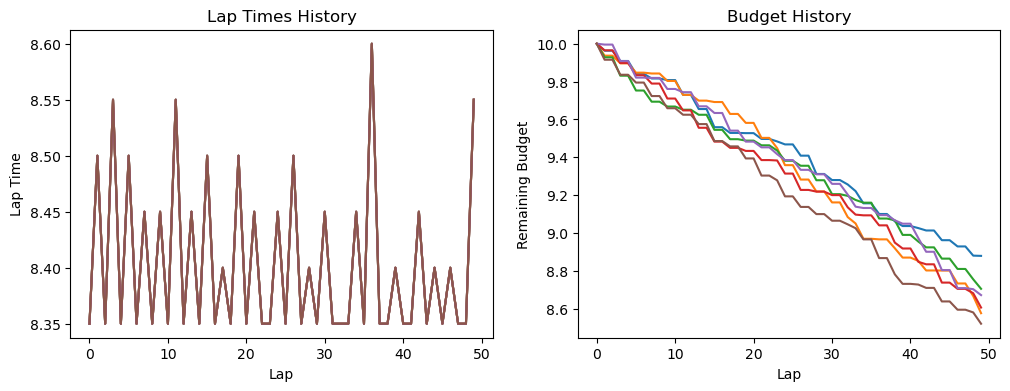

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tqdm import tqdm

# Initialize agent features
def initialize_agent(n, seed=42):
    np.random.seed(seed)
    return np.random.randn(n)

# Compute speed
def speed(agent, track_features):
    norm_agent = np.linalg.norm(agent)
    norm_track = np.linalg.norm(track_features)
    return 1.0 + np.dot(agent, track_features) / (norm_agent * norm_track)

# Generate Fourier-based track feature generator
def generate_fourier(L, n, N=10, kappa=0.25):
    x = np.linspace(0, 1, L)
    track = np.zeros((L, n))
    for j in range(n):
        A0 = np.random.randn()  
        track[:, j] += A0
        for i in range(1, int(N * kappa) + 1):
            An, Bn = np.random.randn(2)
            track[:, j] += An * np.cos(2 * np.pi * i * x) + Bn * np.sin(2 * np.pi * i * x)
    return track

def optimize_agents(agents, lap_times, last_best_lap_time, last_best_agent_state, budgets):
    for i in range(len(agents)):
        if lap_times[i] <= last_best_lap_time[i]:
            last_best_lap_time[i] = lap_times[i]
            last_best_agent_state[i] = agents[i].copy()
            theta = np.random.uniform(-0.1, 0.1)
            u, v = np.random.randn(2, len(agents[i]))
            u /= np.linalg.norm(u)
            v /= np.linalg.norm(v)
            R = np.cos(theta) * np.eye(len(agents[i])) + np.sin(theta) * (np.outer(u, v) - np.outer(v, u))
            agents[i] = np.dot(R, agents[i])
            budgets[i] -= np.abs(theta)
        else:
            agents[i] = last_best_agent_state[i].copy()
    return agents, last_best_lap_time, last_best_agent_state, budgets

def main(num_agents=3, num_laps=10, initial_budget=1.0):
    L, n, dt = 10, 5, 0.05
    agents = [initialize_agent(n) for _ in range(num_agents)]
    track = generate_fourier(L, n)
    budgets = np.full(num_agents, initial_budget)
    last_best_lap_time = np.full(num_agents, np.inf)
    last_best_agent_state = [np.zeros(n) for _ in range(num_agents)]
    
    lap_times_history = np.zeros((num_laps, num_agents))
    budget_history = np.zeros((num_laps, num_agents))
    
    for lap in tqdm(range(num_laps)):
        positions = np.zeros(num_agents)
        lap_times = np.zeros(num_agents)
        while np.any(positions < L):
            s = positions.astype(int) % L
            track_features = track[s]
            v = np.array([speed(agent, tf) for agent, tf in zip(agents, track_features)])
            positions += v * dt
            lap_times += dt
            
        lap_times_history[lap, :] = lap_times
        budget_history[lap, :] = budgets
        
        agents, last_best_lap_time, last_best_agent_state, budgets = optimize_agents(
            agents, lap_times, last_best_lap_time, last_best_agent_state, budgets)
        
    return lap_times_history, budget_history

lap_times_history, budget_history = main(num_agents=6, num_laps=50, initial_budget=10.0)

# plot lap times history and budget history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(lap_times_history)
plt.title('Lap Times History')
plt.xlabel('Lap')
plt.ylabel('Lap Time')
plt.subplot(122)
plt.plot(budget_history)
plt.title('Budget History')
plt.xlabel('Lap')
plt.ylabel('Remaining Budget')
plt.show()




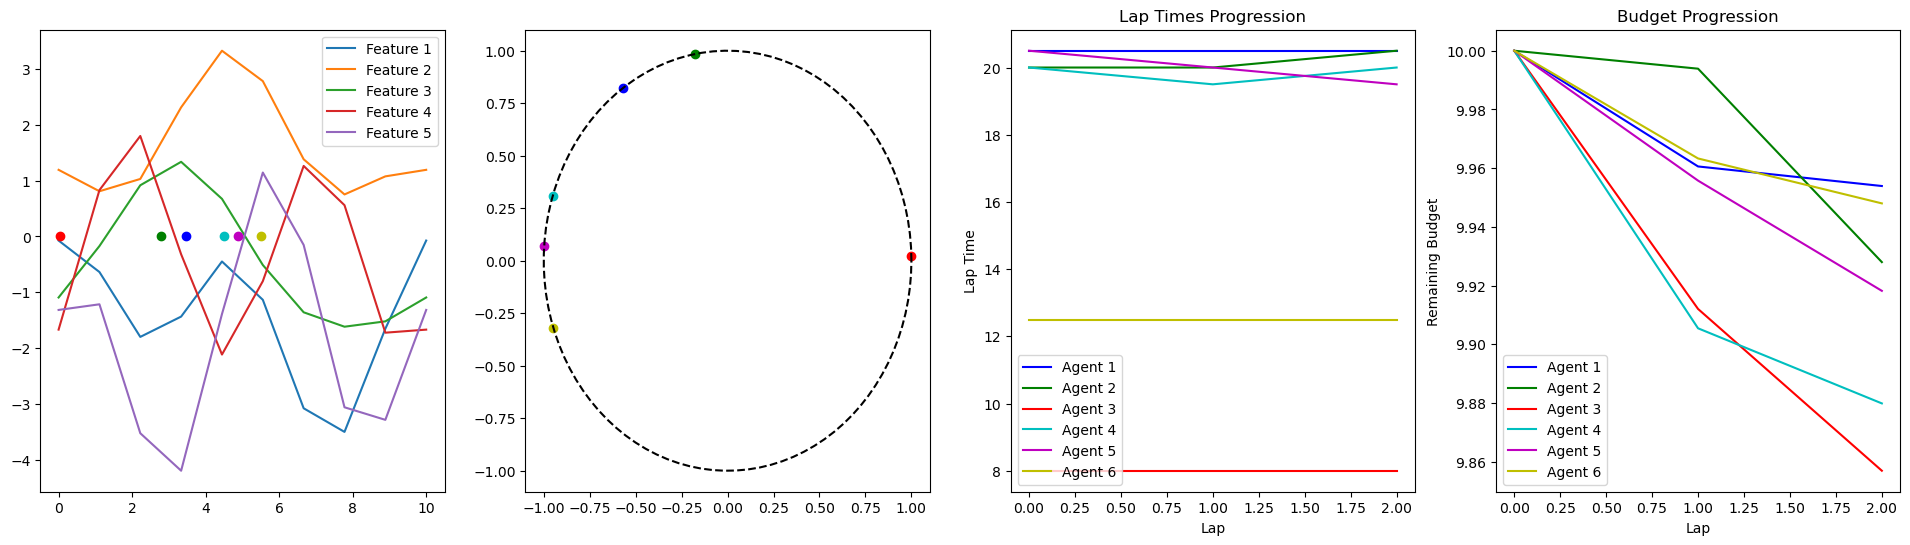

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tqdm import tqdm

LOG_INTERVAL = 1

def generate_fourier_vectorized(L, n, N=10, kappa=0.25):
    x = np.linspace(0, 1, L)
    highest_frequency = int(N * kappa)
    frequencies = np.arange(1, highest_frequency+1)
    A = np.random.randn(n, highest_frequency)
    B = np.random.randn(n, highest_frequency)
    track = np.sum(A[:,:,None] * np.cos(2 * np.pi * frequencies[None, :, None] * x[None,None,:]) +
                   B[:,:,None] * np.sin(2 * np.pi * frequencies[None, :, None] * x[None,None,:]), axis=1)
    track += np.random.randn(n, 1)
    return track.T

def speed_vectorized(agent, track_features, alpha=1.0, beta=1.0):
    dot_product = np.einsum('ij,ij->i', agent, track_features)
    norm_agent = np.linalg.norm(agent, axis=1)
    norm_track = np.linalg.norm(track_features, axis=1)
    return alpha + beta * dot_product / (norm_agent * norm_track)

def rotate_features(agent, theta, u, v):
    """Rotates agent's features in the plane defined by vectors u and v."""
    I = np.identity(len(agent))
    rotation_matrix = (I + (np.cos(theta) - 1) * (np.outer(u, u) + np.outer(v, v)) +
                    np.sin(theta) * (np.outer(u, v) - np.outer(v, u)))
    return np.dot(rotation_matrix, agent)

def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
                budget, agent_idx, min_improvement=0.05, rotation_scale=0.1):
    # Initialize if not provided
    if last_best_lap_time[agent_idx] is None:
        last_best_lap_time[agent_idx] = float('inf')

    if lap_time <= last_best_lap_time[agent_idx]:
        # Update best-known state and lap time
        last_best_agent_state[agent_idx] = np.copy(agent)
        last_best_lap_time[agent_idx] = lap_time

        # Generate random rotation angle and basis vectors
        theta = np.random.uniform(-rotation_scale, rotation_scale)
        u, v = np.random.randn(len(agent)), np.random.randn(len(agent))
        u /= np.linalg.norm(u)
        v /= np.linalg.norm(v)

        # Rotate features
        agent = rotate_features(agent, theta, u, v)
        budget -= np.abs(theta)
    else:
        # Roll back to the best-known state if no improvement
        agent = np.copy(last_best_agent_state[agent_idx])

    return agent, budget

def main(num_agents=3, num_laps=10, initial_budget=1.0, live_plotting=True):
    L, n, alpha, beta, dt = 10, 5, 1.0, 1.0, 0.5
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more colors if needed
    
    track = generate_fourier_vectorized(L, n)
    agents = np.array([np.random.randn(n) for _ in range(num_agents)])
    budgets = np.full(num_agents, initial_budget)
    
    lap_times_history = np.zeros((num_laps, num_agents))
    budget_history = np.zeros((num_laps, num_agents))
    
    last_best_agent_state = np.zeros((num_agents, n))
    last_best_lap_time = np.full(num_agents, np.inf)
    
    if live_plotting:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
        
        # Plot features
        for i in range(n):
            ax1.plot(np.linspace(0, L, L), track[:, i], label=f'Feature {i+1}')
        ax1.legend()
        
        points = [ax1.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
        circles = [ax2.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
        ax2.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--')
    
    for lap in tqdm(range(num_laps)):
        positions = np.zeros(num_agents)
        lap_times = np.zeros(num_agents)
        
        while np.any(positions < L):
            s = np.floor(positions).astype(int) % L
            v = speed_vectorized(agents, track[s])
            positions += v * dt
            
            # Update lap_times only for agents still running
            mask = positions < L
            lap_times[mask] += dt
            
            if live_plotting:
                for i in range(num_agents):
                    points[i].set_data(positions[i] % L, 0)
                    theta = 2 * np.pi * (positions[i] % L) / L
                    circles[i].set_data(np.cos(theta), np.sin(theta))

                clear_output(wait=True)
                display(fig)
                plt.pause(0.01)
                
        lap_times_history[lap, :] = lap_times
        budget_history[lap, :] = budgets
        
        for i in range(num_agents):
            agents[i], budgets[i] = optimize_agent(
                agents[i], lap_times[i], last_best_lap_time,
                last_best_agent_state, budgets[i], i
            )
        
        if live_plotting:
            ax3.clear()
            ax4.clear()
            for i in range(num_agents):
                ax3.plot(range(lap + 1), lap_times_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
                ax4.plot(range(lap + 1), budget_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
            ax3.legend()
            ax4.legend()
            ax3.set_title('Lap Times Progression')
            ax4.set_title('Budget Progression')
            ax3.set_xlabel('Lap')
            ax4.set_xlabel('Lap')
            ax3.set_ylabel('Lap Time')
            ax4.set_ylabel('Remaining Budget')
    
    if not live_plotting:
        # Plot the lap times history and budget history only at the end
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        for i in range(num_agents):
            axs[0].plot(range(num_laps), lap_times_history[:, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
            axs[1].plot(range(num_laps), budget_history[:, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        axs[0].legend()
        axs[1].legend()
        axs[0].set_title('Lap Times Progression')
        axs[1].set_title('Budget Progression')
        axs[0].set_xlabel('Lap')
        axs[1].set_xlabel('Lap')
        axs[0].set_ylabel('Lap Time')
        axs[1].set_ylabel('Remaining Budget')
        plt.show()
    
    return lap_times_history, budget_history


main(num_agents=6, num_laps=50, initial_budget=10.0)
